In [1]:
%matplotlib inline

In [2]:
import datetime

In [3]:
from helper.common_imports import *

In [4]:
from helper import processing_new as ps

# load data

In [5]:
datafolder = './dataset/'
df = pd.read_csv(datafolder+'dataset.pd', index_col=0)

In [6]:
df

,user,surface,finger,class,filename,time
0,user_0,S3,index,touch,0.hdf5,2017-03-08_10:48:36
1,user_0,S3,index,notouch,1.hdf5,2017-03-08_10:50:27
2,user_0,S3,thumb,touch,2.hdf5,2017-03-08_10:52:53
3,user_0,S3,thumb,notouch,3.hdf5,2017-03-08_10:54:12
4,user_0,S3,pinky,touch,4.hdf5,2017-03-08_10:55:51
5,user_0,S3,pinky,notouch,5.hdf5,2017-03-08_10:56:57
6,user_0,S4,index,touch,6.hdf5,2017-03-08_11:01:13
7,user_0,S4,index,notouch,7.hdf5,2017-03-08_11:02:24
8,user_0,S4,thumb,touch,8.hdf5,2017-03-08_11:03:39
9,user_0,S4,thumb,notouch,9.hdf5,2017-03-08_11:04:52


# process dataset

In [ ]:
from helper.projection import projection
import pcl
from sklearn import base, pipeline

In [ ]:
class Process(base.BaseEstimator, base.TransformerMixin):
    def fit(self, x, y=None): return self

    def transform(self, X):

        SIZE = 50
        
        frame, mat, org, ext = X

        pc = projection.pixel_to_point(frame)
        pc_rot = np.dot(mat, (pc - org).reshape((-1,3)).T).T
        pc_rot_org = pc_rot.copy()

        CLOUD_UPPER_MIN = 0.01  # 1cm, which exclude the plane
        CLOUD_UPPER_MAX = 0.10
        xm = (pc_rot[:,0] >= ext[0]) & (pc_rot[:,0] <= ext[1])
        ym = (pc_rot[:,1] >= ext[2]) & (pc_rot[:,1] <= ext[3])
        zm = (pc_rot[:,2] > CLOUD_UPPER_MIN) & (pc_rot[:,2] < CLOUD_UPPER_MAX)
        pc_rot = pc_rot[xm & ym & zm]

        if pc_rot.shape[0] == 0:
            return np.zeros((SIZE,SIZE))

        leaf_size = 0.02
        vpcl = pcl.PointCloud(pc_rot.astype(np.float32))
        vgf = vpcl.make_voxel_grid_filter()
        vgf.set_leaf_size(leaf_size, leaf_size, leaf_size)
        voxel = vgf.filter().to_array()

        closest_y = voxel[np.argsort(voxel[:,1])[-1]]
        track_point_idx_ = np.argmin(np.linalg.norm(pc_rot_org - closest_y, axis=1))
        track_point_idx = np.unravel_index(track_point_idx_, frame.shape)

        # reorient pointcloud
        tmp = pc_rot_org * np.array([-1,1,1], dtype=np.float32) + org
        tmp = np.ascontiguousarray(tmp)
        frame_ = projection.point_to_pixel(tmp)

        # mean at plane
        frame_nz = (frame_ != 0)
        frame_[frame_nz] -= frame_[frame_nz].mean()
        
        # clip
        r = np.argwhere(projection.point_to_pixel((closest_y * np.array([-1,1,1], dtype=np.float32) +org).reshape((1,3))))[0]
        frame_clip = frame_[r[0]-50:r[0]+50, r[1]-50:r[1]+50]
        
        # pad if needed
        if frame_clip.shape != (100,100):
            frame_clip = np.pad(frame_clip, [(0, 100 - frame_clip.shape[0]), (0, 100 - frame_clip.shape[1])])
        
        # resize
        from skimage.transform import resize
        image_resized = resize(frame_clip, (frame_clip.shape[0] // 2, frame_clip.shape[1] // 2),
                               anti_aliasing=True)
        
        # norm betweewn fixed dimensions
        # tmp = image_resized.reshape(-1)
        # tmp -= tmp.min()
        # tmp /= tmp.max()
        # image_resized_norm = tmp.reshape((50,50))
        tmp = image_resized
        # tmp[tmp < 0] = 0
        tmp[tmp > 0.04] = 0
        tmp /= 0.04
        return tmp

In [ ]:
def process_dataset(args):
    i, row = args

    ## X
    filename = row['filename']

    hf = h5py.File('./dataset/'+filename, 'r')
    x = hf['data/depth']
    org = np.array(hf['origin'], dtype=np.float32)
    mat = np.array(hf['matrix'], dtype=np.float32)
    ext = np.array(hf['extrema'], dtype=np.float32)

    t1 = datetime.datetime.now()

    pl = pipeline.Pipeline([
            ('process', Process()),
        ], verbose=True)

    td = ps.TraverseDataset(x, mat, org, ext, pl)
    res = td.compute()
    print("classification {} for {} frames".format(datetime.datetime.now() - t1, x.shape[0]))
    return res

In [ ]:
%%time
from multiprocessing import Pool
pool = Pool(processes=6)
Xc = pool.map(process_dataset, df.iterrows())

In [ ]:
Xc = np.array(Xc)

# save, load, preprocess data

In [ ]:
np.save('Xc_norm_1', Xc)

In [7]:
Xc = np.load('Xc_norm_1.npy')

# split

In [8]:
S3 = df['surface'] == 'S3'
S4 = df['surface'] == 'S4'

index = df['finger'] == 'index'
thumb = df['finger'] == 'thumb'
pinky = df['finger'] == 'pinky'

def df_id(condition):
    return df.index[condition].values

kfolds = [(df_id(S3), df_id(S4)),
          (df_id(S4), df_id(S3)),
          (np.hstack([df_id(index), df_id(thumb)]), df_id(pinky)),
          (np.hstack([df_id(index), df_id(pinky)]), df_id(thumb)),
          (np.hstack([df_id(pinky), df_id(thumb)]), df_id(index)),
         ]

In [9]:
for train, test in kfolds:
    print("%s %s" % (train, test))

[0 1 2 3 4 5] [ 6  7  8  9 10 11]
[ 6  7  8  9 10 11] [0 1 2 3 4 5]
[0 1 6 7 2 3 8 9] [ 4  5 10 11]
[ 0  1  6  7  4  5 10 11] [2 3 8 9]
[ 4  5 10 11  2  3  8  9] [0 1 6 7]


# CNN

In [10]:
# import os
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [11]:
import keras

Using TensorFlow backend.


In [53]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

num_classes = 2
epochs = 3

# input image dimensions
SIZE = 50
img_rows, img_cols = SIZE, SIZE

# the data, split between train and test sets
# (x_train, y_train), (x_test, y_test) = mnist.load_data()


for train_id, test_id in [kfolds[3]]:

    print(train_id, test_id)
#     Xc = np.frombuffer(Xc_shared.get_obj()).reshape((12,900,25))
    y = np.tile(np.r_[np.ones(900), np.zeros(900)], 6).reshape(12, 900)

    x_train = np.r_[tuple([Xc[i] for i in train_id])]
    x_test  = np.r_[tuple([Xc[i] for i in test_id])]

    y_train = y[train_id].reshape(-1)
    y_test  = y[test_id].reshape(-1) 

[ 0  1  6  7  4  5 10 11] [2 3 8 9]


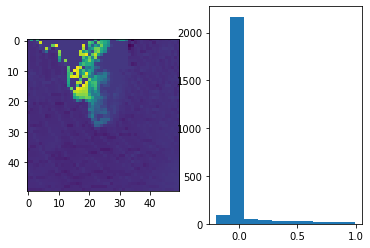

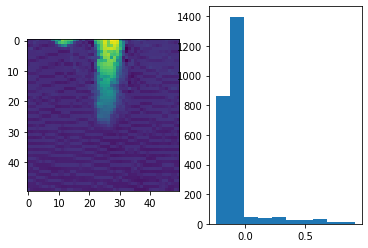

In [54]:
fig, ax = plt.subplots(1,2)
tmp_ = x_train[100] #/ x_train[0].max()
ax[0].imshow(tmp_)
_=ax[1].hist(tmp_.reshape(-1))

X = 799
fig, ax = plt.subplots(1,2)
ax[0].imshow(x_train[X])
_=ax[1].hist(x_train[X].reshape(-1))

In [55]:
# from sklearn.preprocessing import StandardScaler

# x_train = StandardScaler(with_std=False).fit_transform(x_train.reshape(-1,1))
# x_train = x_train.reshape((-1,img_rows, img_cols))
# x_test = StandardScaler(with_std=False).fit_transform(x_test.reshape(-1,1))
# x_test = x_test.reshape((-1,img_rows, img_cols))

In [56]:
K.image_data_format()

'channels_last'

In [57]:
x_train.shape

(7200, 50, 50)

In [58]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# x_train /= 2**15
# x_test /= 2**15
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (7200, 50, 50, 1)
7200 train samples
3600 test samples


In [113]:
batch_size = 8

model = Sequential()
model.add(Conv2D(4, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(8, (7, 7), activation='relu'))
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [114]:
def model_str(model):
    model_str = []
    for layer in model.layers:
        if layer.__class__ is Conv2D:
            s = 'C2D-'+str(layer.filters)+'-'+"x".join([str(i) for i in layer.kernel_size])
            model_str.append(s)
        if layer.__class__ is Dense:
            s = 'DNS-'+str(layer.output_shape[1])
            model_str.append(s)
    
    init_op = tf.initialize_all_variables()
    sess = tf.Session()
    sess.run(init_op)
    with sess.as_default():
        if model.optimizer.__class__ is keras.optimizers.RMSprop:
            model_str.append('RMS-'+str(model.optimizer.lr.eval()))
        if model.optimizer.__class__ is keras.optimizers.Adagrad:
            model_str.append('Adag-'+str(model.optimizer.lr.eval()))

    model_str.append('BS-'+str(batch_size))
    
    return "_".join(model_str)

In [115]:
model_str(model)

'C2D-4-3x3_C2D-8-7x7_DNS-32_DNS-1_RMS-0.001_BS-8'

In [116]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 48, 48, 4)         40        
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 42, 42, 8)         1576      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 8)           0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 8, 8, 8)           0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 32)                16416     
_________________________________________________________________
dropout_29 (Dropout)         (None, 32)                0         
__________

In [117]:
%%time
logname = './Graph/' + model_str(model) +'_'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

cb = keras.callbacks.TensorBoard(log_dir=logname, histogram_freq=0, write_graph=True, write_images=True)

history = model.fit(x_train, y_train.astype(int),
                    batch_size=batch_size,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[cb],
                    initial_epoch=0,
                   )

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7200 samples, validate on 3600 samples
Epoch 1/50
7200/7200 [==============================] - 42s 6ms/step - loss: 0.4591 - acc: 0.7867 - val_loss: 0.4968 - val_acc: 0.7836
Epoch 2/50
7200/7200 [==============================] - 40s 6ms/step - loss: 0.3180 - acc: 0.8753 - val_loss: 0.4224 - val_acc: 0.8258
Epoch 3/50
7200/7200 [==============================] - 40s 6ms/step - loss: 0.2709 - acc: 0.8914 - val_loss: 0.2932 - val_acc: 0.8711
Epoch 4/50
7200/7200 [==============================] - 41s 6ms/step - loss: 0.2453 - acc: 0.8990 - val_loss: 0.4856 - val_acc: 0.8197
Epoch 5/50
7200/7200 [==============================] - 42s 6ms/step - loss: 0.2343 - acc: 0.9107 - val_loss: 0.3691 - val_acc: 0.8536
Epoch 6/50
7200/7200 [==============================] - 42s 6ms/step - loss: 0.2159 - acc: 0.9156 - val_loss: 0.3328 - val_acc: 0.8781
Epoch 7/50
7200/7200 [==============================] - 42s 6ms/step - loss: 0.2083 - acc: 0.9249 - val_loss: 0.2968 - val_acc: 0.8869
Epoch 8

KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(16,4))
# summarize history for accuracy
axs[0].plot(history.history['acc'])
axs[0].plot(history.history['val_acc'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'test'], loc='upper left')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
_=axs[1].legend(['train', 'test'], loc='upper left')

In [ ]:
from sklearn import metrics

In [ ]:
fig, ax = plt.subplots()
y_pred = model.predict(x_test)
fpr, tpr, thr = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax.legend(loc="lower right")    